<a href="https://colab.research.google.com/github/Jiho-korea/DeepLearning/blob/master/kaggle_4%EC%98%88%EC%A0%9C4_%EC%88%AB%EC%9E%90%EC%9D%B8%EC%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [37]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # 합성곱 층
from keras.layers import Dense, Dropout, Flatten # 풀링 층 + 연결층 

from keras.layers.normalization import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator

from keras.utils.np_utils import to_categorical

import imageio

In [38]:
# 데이터 읽기
train = pd.read_csv('/gdrive/My Drive/Colab Notebooks/DeepLearningPrac/tensorflowPrac/multinomial/kaggle/train.csv')
test = pd.read_csv('/gdrive/My Drive/Colab Notebooks/DeepLearningPrac/tensorflowPrac/multinomial/kaggle/test.csv')
sub = pd.read_csv('/gdrive/My Drive/Colab Notebooks/DeepLearningPrac/tensorflowPrac/multinomial/kaggle/sample_submission.csv')

In [82]:
img_digit_list = []
for i in range(1,10):
  file_name = "/gdrive/My Drive/Colab Notebooks/DeepLearningPrac/tensorflowPrac/multinomial/kaggle/" +  str(i) +".png"
  img_digit_list.append(imageio.imread(file_name, as_gray=True))

In [83]:
img_digit_array = np.array(img_digit_list)

In [84]:
img_digit_array.shape

(9, 28, 28)

In [85]:
img_digit_array = 255.0 - img_digit_array.reshape(-1,784)
img_digit_array = (img_digit_array/ 255.0 * 0.99) + 0.01

In [86]:
img_digit_array = img_digit_array.reshape(-1,28,28,1)

In [87]:
img_digit_array.shape

(9, 28, 28, 1)

In [47]:
# shape 확인
print("학습용 데이터 셋 : {0}\n테스트용 데이터 셋 : {1}".format(train.shape, test.shape))

학습용 데이터 셋 : (42000, 785)
테스트용 데이터 셋 : (28000, 784)


In [48]:
# 학습용 피쳐, 레이블 데이터 numpy,ndarray 타입으로 추출
X = train.drop(['label'], 1).values
y = train['label'].values

# 테스트용 피쳐 데이터 넘파이 배열로 추출
test_x = test.values

In [49]:
# 피쳐 데이터 정규화 (이미지 데이터는 픽셀마다 0~255 사이의 값을 가지므로 이를 255로 나눠 0~1 사이의 값으로 맞춤)
X = X / 255.0
test_x = test_x / 255.0

In [50]:
# 3개의 차원으로 reshape (이미지 개수 , 높이 = 28px, 너비 = 28px , 컬러채널 = 1)
# canal = 1 => 흑백 사진이므로 컬러채널 1로 설정
X = X.reshape(-1,28,28,1)
test_x = test_x.reshape(-1,28,28,1)

In [51]:
# 레이블 인코딩 (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y = to_categorical(y)

print("레이블 데이터 shape {0}".format(y.shape))

레이블 데이터 shape (42000, 10)


In [52]:
# 학습용 , 테스트용 데이터 세트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [53]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(37800, 28, 28, 1) (4200, 28, 28, 1) (37800, 10) (4200, 10)


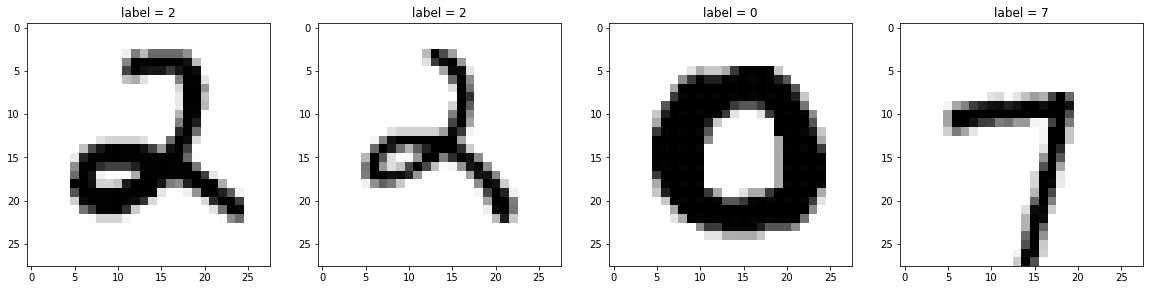

In [54]:
# 데이터 시각화 -> 피쳐(이미지), 레이블(숫자) 출력  
X_train__ = X_train.reshape(X_train.shape[0], 28, 28)

fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train__[i], cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title = "label = {0}".format(digit)); # 학습용 이므로 레이블 데이터가 일치함

In [55]:
# 피쳐 데이터 정규화 함수
mean = np.mean(X_train)
std = np.std(X_train)

def standardize(x):
    return (x-mean)/std

In [56]:
# epochs, batch_size 설정
# epochs = 50
epochs = 3
batch_size = 64

In [57]:
model=Sequential()

# 합성곱 층
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
# 풀링 층
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
# 합성곱 층
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
# 풀링 층
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
# 합성곱 층    
model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
# 풀링 층
model.add(MaxPooling2D(pool_size=(2,2)))

# 완전 연결 층
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512,activation="relu"))
    
model.add(Dense(10,activation="softmax"))
# 손실 함수 -> 크로스 엔트로피    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [58]:
# 과대적합을 방지하는 코드

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=batch_size)
test_gen = datagen.flow(X_test, y_test, batch_size=batch_size)

In [59]:
# 모델 학습
history = model.fit_generator(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              validation_data = test_gen,
                              validation_steps = X_test.shape[0] // batch_size)

Epoch 1/3
590/590 [==============================] - 285s 483ms/step - loss: 0.1562 - accuracy: 0.9502 - val_loss: 0.1509 - val_accuracy: 0.9447
Epoch 2/3
590/590 [==============================] - 288s 488ms/step - loss: 0.0684 - accuracy: 0.9793 - val_loss: 0.1674 - val_accuracy: 0.9751
Epoch 3/3
590/590 [==============================] - 285s 483ms/step - loss: 0.0576 - accuracy: 0.9820 - val_loss: 0.0035 - val_accuracy: 0.9811


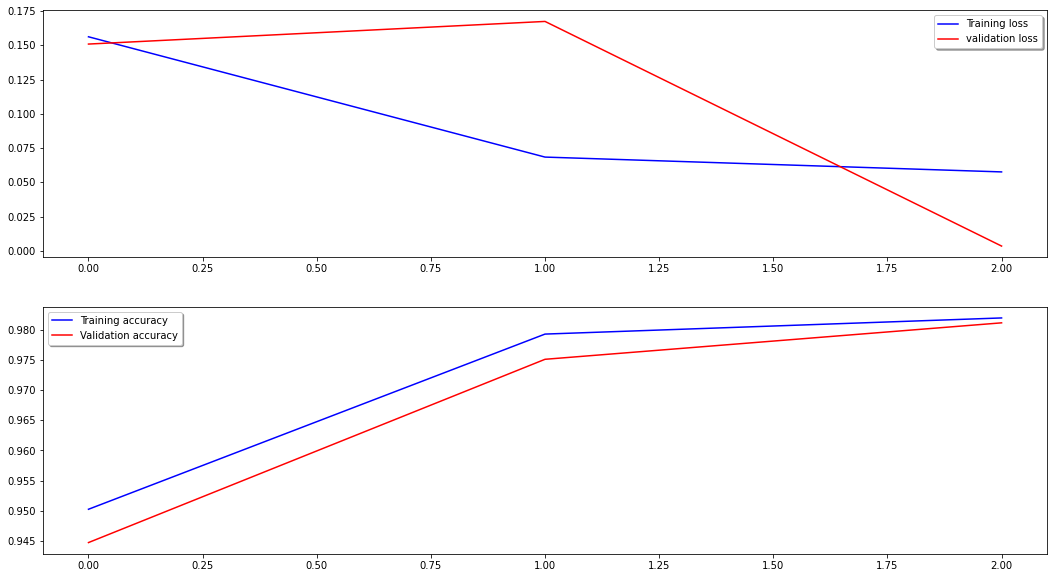

In [60]:
# 학습-검증 폴드 정확도, 손실함수 학습 곡선 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

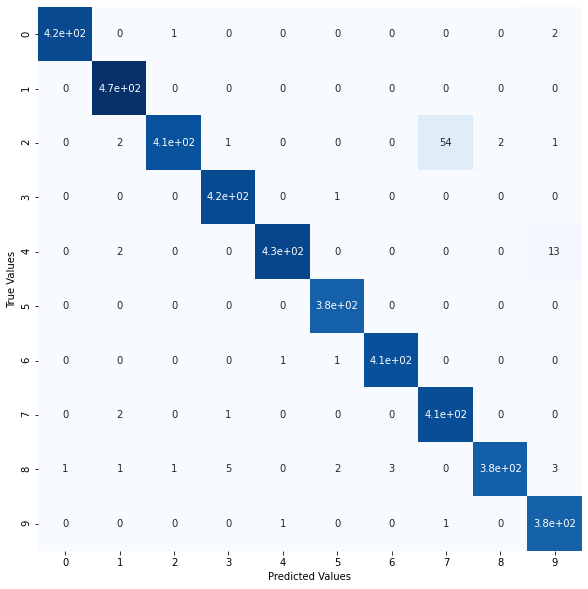

In [61]:
# 테스트용 피쳐 데이터셋으로 예측한 예측 값들과 테스트용 레이블 세트 쉽게 비교
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.predict(X_test) # Predict encoded label as 2 => [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

#레이블 디코딩 (argmax 로 레코드중 가장 높은 값(1)을 가진 인덱스를 반환)
Y_pred = np.argmax(y_pred, 1) 
Y_test = np.argmax(y_test, 1) 

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

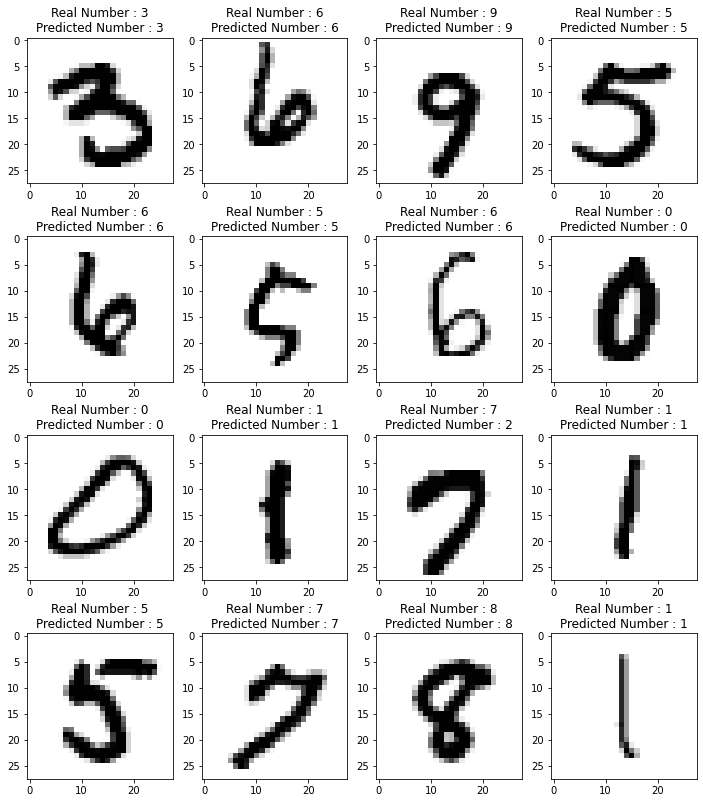

In [62]:
#16 개의 예측 값과 테스트 값 비교
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Number : {y_test[i].argmax()}\nPredicted Number : {y_pred[i].argmax()}");

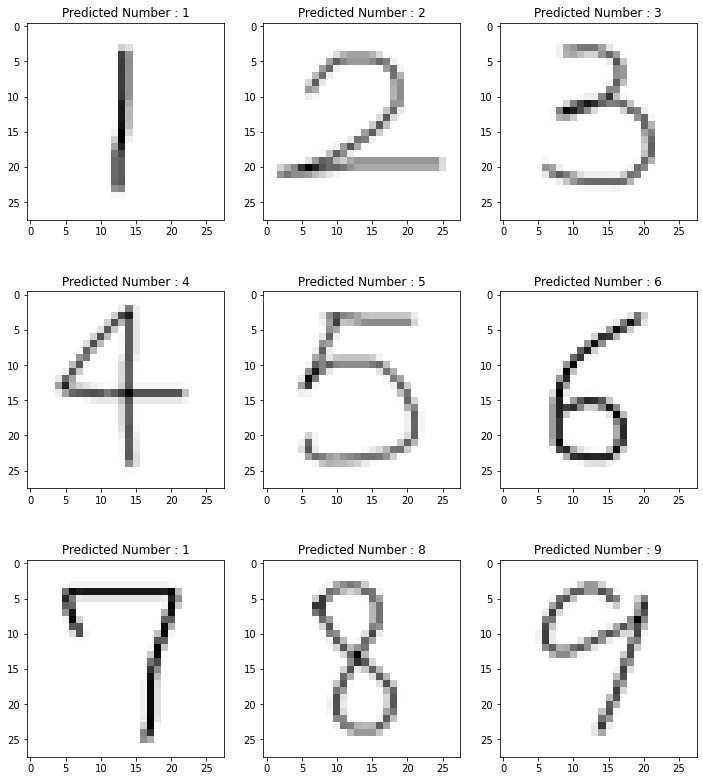

In [88]:
#내가 쓴 손글씨 6개 예측해보기
pred_digit = model.predict(img_digit_array)
img_digit_array__ = img_digit_array.reshape(img_digit_array.shape[0], 28, 28)

fig, axis = plt.subplots(3, 3, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(img_digit_array__[i], cmap='binary')
    ax.set(title = f"Predicted Number : {pred_digit[i].argmax()}");

In [65]:
print(str(np.mean(y_pred.argmax(axis=1) == y_test.argmax(axis=1)) * 100)[:6],"%",sep="")

97.571%


In [66]:
pred = model.predict_classes(test_x, verbose=1)

28000/28000 [==============================] - 53s 2ms/step


In [67]:
sub['Label'] = pred
sub.to_csv("/gdrive/My Drive/Colab Notebooks/DeepLearningPrac/tensorflowPrac/multinomial/kaggle/CNN_keras_sub.csv", index=False)
sub.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
